# Results

In [ ]:
pip install rpy2 rpy2-arrow

DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import polars as pl
import pandas as pd
import numpy as np

import altair as alt
import seaborn as sns


from pathlib import Path
import astropy.constants as const
import vegafusion as vf
vf.enable(row_limit = int(1e6))

import rpy2
import rpy2_arrow.arrow as pyra
from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

base = importr('base')

# Apply the default theme
sns.set_theme()
from utils import *

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


2023-09-18 01:24:01.592 | DEBUG    | utils:download_and_read_file:109 - Reading /Users/zijin/juno/JNO-SS-3-FGM-CAL-V1.0/INDEX/INDEX.LBL
2023-09-18 01:24:01.619 | DEBUG    | utils:download_and_read_file:109 - Reading /Users/zijin/juno/JNO-J-3-FGM-CAL-V1.0/INDEX/INDEX.LBL


In [ ]:
%%R
library(ggplot2)
library(ggpubr)
library(viridis)

library(glue)
library(arrow)

In [ ]:
conv_pl = rpy2.robjects.conversion.Converter(
    'Pandas to pyarrow',
    template=pyra.converter)

@conv_pl.py2rpy.register(pl.DataFrame)
def py2rpy_pandas(dataf: pl.DataFrame):
    pa_tbl = dataf.to_arrow()
    return base.as_data_frame(pa_tbl)
    # return pyra.converter.py2rpy(pa_tbl) # NOTE: not working for ggplot2

conv_pl = rpy2.ipython.rmagic.converter + conv_pl

In [ ]:
# read candidates from files in current directory
pattern = 'data/candidates_*.parquet'
data = Path() / pattern
au_in_km = const.au.to("km").value

In [ ]:
candidates_pl = pl.scan_parquet(data).with_columns(
    (pl.col(["X", "Y", "Z"]) / au_in_km).map_alias(lambda col: col+"_in_AU"),
).sort("time").collect()

## Analysis

### Magnetic field strength vs. distance

In [ ]:
file = f"data/jno_*.parquet"
lazy_df = pl.scan_parquet(file)


In [ ]:
b_cols = ["BX", "BY", "BZ"]

every = "3d"
b_df = (
    lazy_df.with_columns(
        pl_norm(b_cols).alias("B"),)
    .sort("time")
    .group_by_dynamic("time", every=every)
    .agg(
        pl.mean("B").alias("B_mean"),
    )
    .collect()
)

In [ ]:
alt.Chart(b_df).mark_line().encode(
    x="time",
    y="B_mean",
)

alt.Chart(...)

In [ ]:
binwidth = 0.1

b_df = (
    lazy_df.with_columns(
        (pl.col('X')/au_in_km / binwidth).floor().alias('bin_group_id').cast(pl.Int64),
        pl_norm(b_cols).alias("B"),
    ).group_by("bin_group_id").agg(
        pl.mean("B").alias("B_mean"),
    ).with_columns(
        (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
    ).collect()
)

PARTITIONED DS


In [ ]:
alt.Chart(b_df).mark_line().encode(
    x=alt.X("binned_distance").title("Distance from Sun (AU)"),
    y=alt.Y("B_mean").title("Magnetic Field Strength (nT)"),
)

alt.Chart(...)

### Distance and Occurrence rates versus time

In [ ]:
properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(X_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2

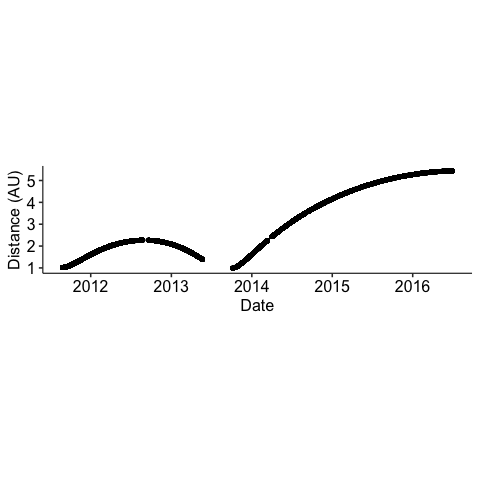

In [ ]:
%%R -i candidates_pl -c conv_pl

p <- ggplot(candidates_pl, aes(x = time, y = X_in_AU)) + 
  geom_point() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
filename <- "distance_by_date"
# ggsave(glue("images/{filename}.png"))
# ggsave(glue("images/{filename}.pdf"))
p

Plot the occurernce rate of each type of IDs as a function of time

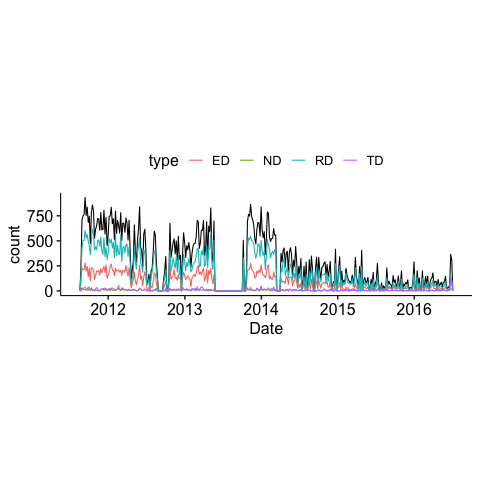

In [ ]:
%%R -i candidates_pl -c conv_pl
candidates_pl$date_only <- as.Date(candidates_pl$time)
binwidth <- 5
p <- ggplot(candidates_pl, aes(x = date_only)) + 
  geom_freqpoly(binwidth = binwidth) + # Overall frequency by day
  geom_freqpoly(aes(color = type), binwidth = binwidth) + # Frequency by day split by typeH
  labs(x = "Date") +
  theme_pubr(base_size = 16) +
  theme(aspect.ratio=0.25)

filename <- "count_raw"
# ggsave(glue("images/{filename}.png"))
# ggsave(glue("images/{filename}.pdf"))
p

The following codes deal with data gap better by filling the gap with the `null` value.

In [ ]:
every = pd.Timedelta("3d")
base_amplification_factor = every / pd.Timedelta("1d")

temp_df = (
    candidates_pl.filter(
        pl.col("time") < pd.Timestamp("2016-05-01") # There is a sudden increase in the number of TD candidates after this date
    )
    .with_columns(
        pl.col("time").dt.truncate(every).alias("truncated_time")
    )
    .group_by("truncated_time")
    .agg(
        (pl.count()/base_amplification_factor),
        pl.mean("X_in_AU"),
    )
)

df = temp_df.upsample("truncated_time", every=every)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


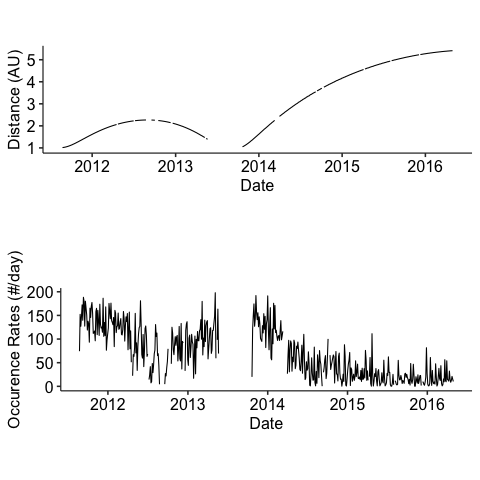

In [ ]:
%%R -i df -c conv_pl

df$date <- as.Date(df$truncated_time)
p1 <- ggplot(df, aes(x = date, y = X_in_AU)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
p2 <- ggplot(df, aes(x = date, y = count)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Occurrence Rates (#/day)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

p <- ggarrange(p1, p2, nrow = 2)

filename <- "distance_and_or"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

As we can see different types of IDs have different Occurrence rates. To demonstrate their relative change, amplify TD-like IDs by 10 times.

In [ ]:
every = pd.Timedelta("5d")
base_amplification_factor = every / pd.Timedelta("1d")

temp_df = (
    candidates_pl.filter(
        pl.col("time") < pd.Timestamp("2016-05-01") # There is a sudden increase in the number of TD candidates after this date
    )
    .with_columns(
        pl.col("time").dt.truncate(every).alias("truncated_time")
    )
    .group_by("truncated_time", "type")
    .agg(
        pl.count(),
        pl.mean("X_in_AU"),
    )
)

amplification_factors = {
    "RD" : 1 / base_amplification_factor,
    "ED" : 1 / base_amplification_factor,
    "TD" : 10 / base_amplification_factor,
    "ND" : 10 / base_amplification_factor,
}

type_dfs = []
for type, data in temp_df.group_by("type"):
    
    type_df = (
        data.sort("truncated_time")
        .upsample("truncated_time", every=every)
        .with_columns(
            pl.col("type").fill_null(type),
            (pl.col("count") * amplification_factors[type])
        )
    )
    type_dfs.append(type_df)

df = pl.concat(type_dfs)

Saving 6.67 x 6.67 in image


Saving 6.67 x 6.67 in image


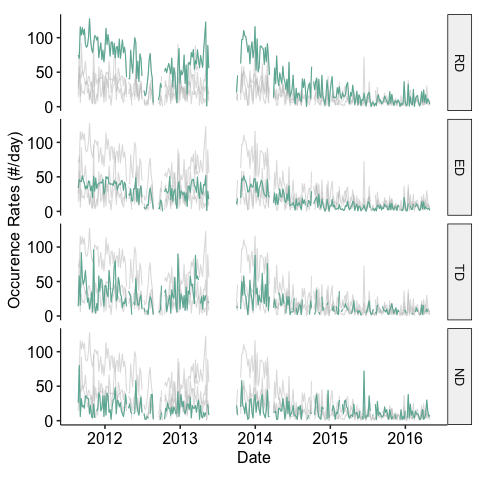

In [ ]:
%%R -i df -c conv_pl

tmp <- df %>%
  mutate(name2=type)
tmp$date <- as.Date(tmp$truncated_time)
tmp$type <- factor(tmp$type, levels = c("RD", "ED", "TD", "ND"))

p <- tmp %>%
  ggplot( aes(date, count)) +
    geom_line( data=tmp %>% dplyr::select(-type), aes(group=name2), color="grey", size=0.5, alpha=0.5) +
    geom_line( aes(color=type), color="#69b3a2")+
    facet_grid(type ~ .) +
    labs(x = "Date", y = "Occurrence Rates (#/day)") +
    theme_pubr(base_size = 16) +
    theme(
      aspect.ratio=0.25
    )

filename <- "count_am"  
ggsave(filename = glue("images/{filename}.png"))
ggsave(filename = glue("images/{filename}.pdf"))
p

#### Histogram of Occurrence rates

In [ ]:
candidates_rd_like = candidates_pl.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

candidates_td_like = candidates_pl.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In addition: Warning message:
Using `bins = 30` by default. Pick better value with the argument `bins`. 


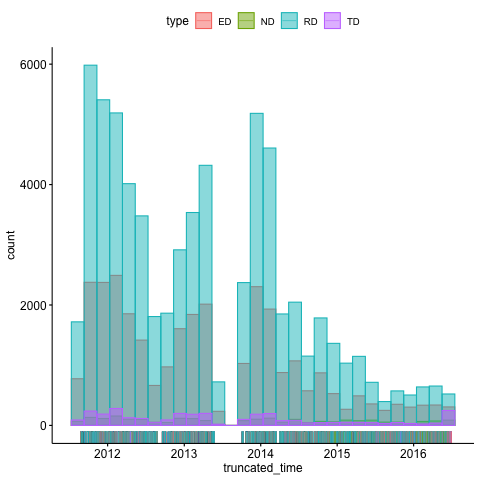

In [ ]:
%%R -i candidates_pl -c conv_pl

gghistogram(candidates_pl, x = "truncated_time",
   rug = TRUE,
   color = "type", fill = "type",
   )

In addition: Warning message:
Using `bins = 30` by default. Pick better value with the argument `bins`. 


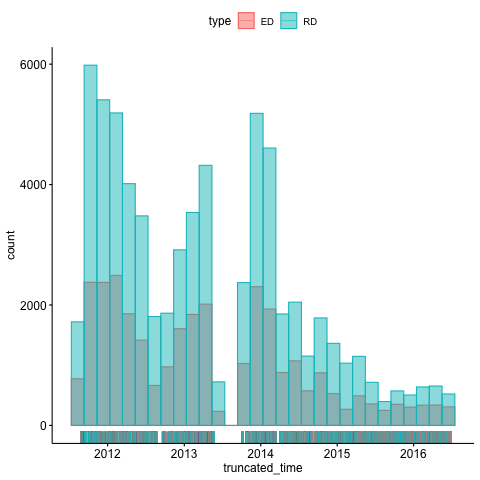

In [ ]:
%%R -i candidates_rd_like -c conv_pl

gghistogram(candidates_rd_like, x = "truncated_time",
   rug = TRUE,
   color = "type", fill = "type",
   )

In addition: Warning message:
Using `bins = 30` by default. Pick better value with the argument `bins`. 


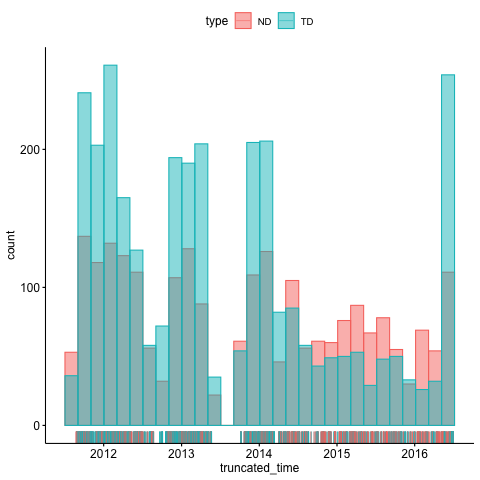

In [ ]:
%%R -i candidates_td_like -c conv_pl

gghistogram(candidates_td_like, x = "truncated_time",
   rug = TRUE,
   color = "type", fill = "type",
   )

### Occurrence rates versus distance

In [ ]:
temp_candidates_pl = candidates_pl.filter(
    pl.col("time") > pd.Timestamp("2013-06-01")  # Where distance increases singularly
)

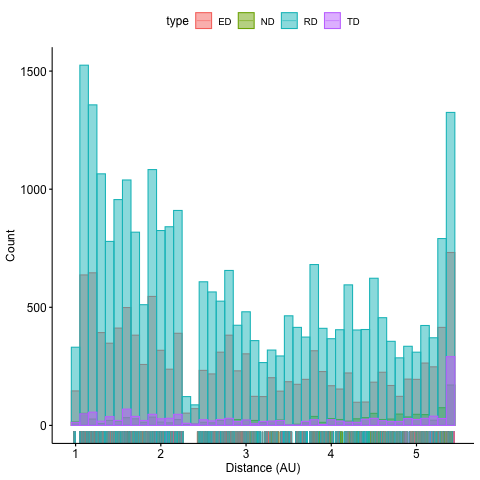

In [ ]:
%%R -i temp_candidates_pl -c conv_pl
gghistogram(temp_candidates_pl, x="X_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count")


In [ ]:
candidates_rd_like = temp_candidates_pl.filter(  
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

candidates_td_like = temp_candidates_pl.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

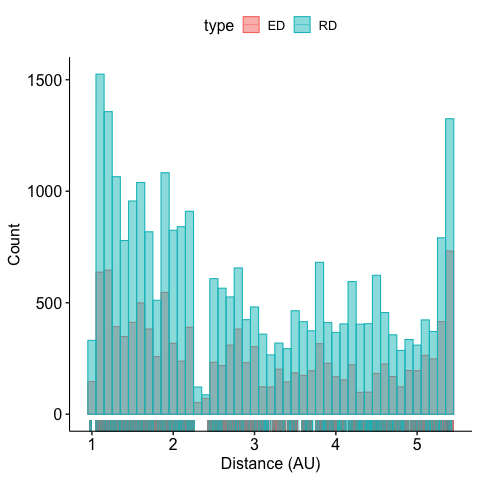

In [ ]:
%%R -i candidates_rd_like -c conv_pl

gghistogram(candidates_rd_like, x="X_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)


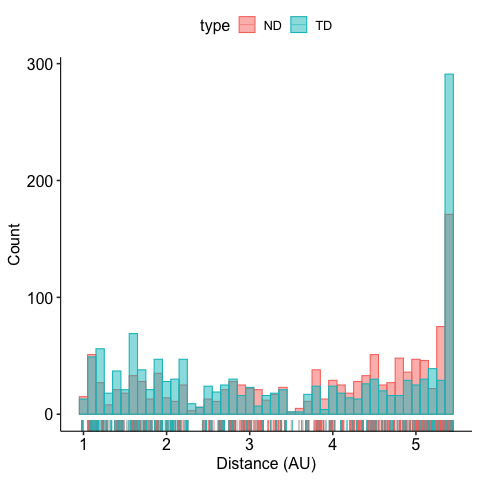

In [ ]:
%%R -i candidates_td_like -c conv_pl

gghistogram(candidates_td_like, x="X_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)


In [ ]:
binwidth = 0.1
temp_df = temp_candidates_pl.with_columns(
    (pl.col('X_in_AU')/binwidth).floor().alias('bin_group_id').cast(pl.Int64),
).group_by("bin_group_id",'type').agg(
    (pl.max("time") - pl.min("time")).alias("duration"),
    pl.col('X_in_AU').mean().alias("mean_distance"),
    pl.count()
).with_columns(
    (pl.col("duration") / pd.Timedelta(hours=24)).alias("duration_in_days"),
).filter(
    pl.col("duration_in_days") > 1 # filter out candidates that occur within 1 day
).with_columns(
    (pl.col("count") / pl.col("duration_in_days")).alias("occurrence_rate")
).sort(
    "bin_group_id"
)

In [ ]:
_ = pl.DataFrame({'bin_group_id': pl.arange(temp_df['bin_group_id'].min(), temp_df['bin_group_id'].max()+1, eager=True)})

type_dfs = []
for type, data in temp_df.group_by("type"):
    type_df = _.join(data, on="bin_group_id", how="left").with_columns(
            pl.col("type").fill_null(type),
        )
    type_dfs.append(type_df)

or_df = pl.concat(type_dfs).with_columns(
    (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
)

Saving 6.67 x 6.67 in image


Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 4 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 4 rows containing missing values (`geom_point()`). 
2: Removed 4 rows containing missing values (`geom_point()`). 


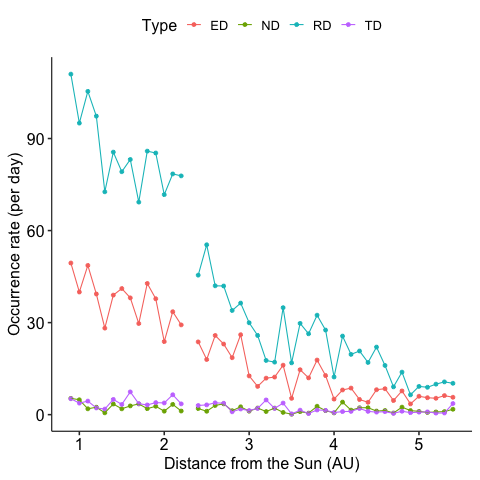

In [ ]:
%%R -i or_df -c conv_pl
p <- ggplot(or_df, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

In [ ]:
candidates_rd_like = or_df.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

candidates_td_like = or_df.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggplot(candidates_rd_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_rd"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 2 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 2 rows containing missing values (`geom_point()`). 
2: Removed 2 rows containing missing values (`geom_point()`). 


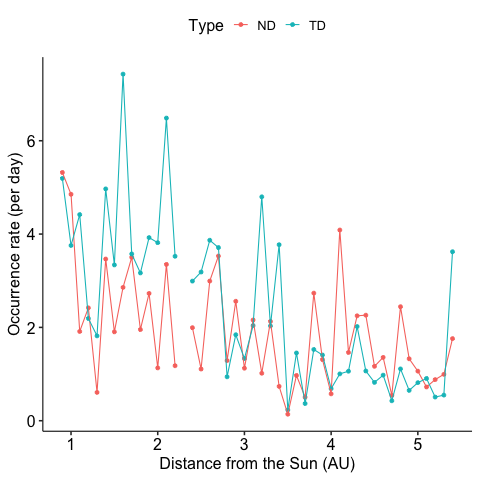

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggplot(candidates_td_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_td"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite values (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing non-finite values (`stat_cor()`). 

R[write to console]: 3: Removed 2 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 2 rows containing non-finite values (`stat_smooth()`). 
2: Removed 2 rows containing non-finite values (`stat_cor()`). 
3: Removed 2 rows containing missing values (`geom_point()`). 
4: Removed 2 rows containing non-finite values (`stat_smooth()`). 
5: Removed 2 rows containing non-finite values (`stat_cor()`). 
6: Removed 2 rows containing missing values (`geom_point()`). 


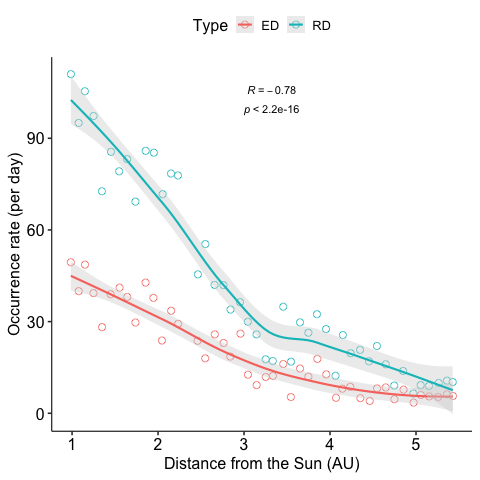

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggscatter(candidates_rd_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_rd"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite values (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing non-finite values (`stat_cor()`). 

R[write to console]: 3: Removed 2 rows containing missing values (`geom_point()`). 



In addition: Warning messages:
1: Removed 2 rows containing non-finite values (`stat_smooth()`). 
2: Removed 2 rows containing non-finite values (`stat_cor()`). 
3: Removed 2 rows containing missing values (`geom_point()`). 
4: Removed 2 rows containing non-finite values (`stat_smooth()`). 
5: Removed 2 rows containing non-finite values (`stat_cor()`). 
6: Removed 2 rows containing missing values (`geom_point()`). 


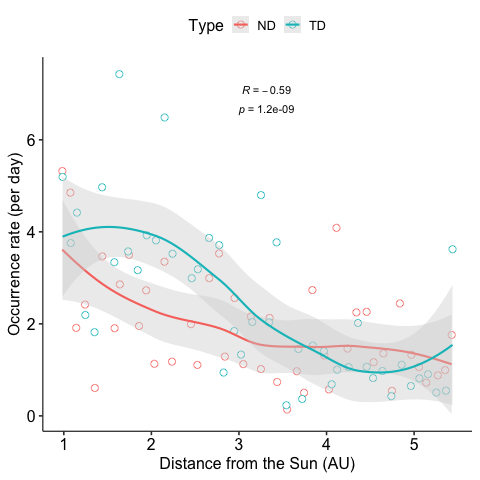

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggscatter(candidates_td_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
filename <- "or_by_distance_td_fit"
ggsave(glue("images/{filename}.png"))
ggsave(glue("images/{filename}.pdf"))
p

### Plotting candidates of different types of discontinuities

In [ ]:
# alt.Chart(candidates).mark_point().encode(
#     x='yearmonth(time)',
#     y='count()',
#     color='type',
# )

In [ ]:
alt.Chart(candidates_pl.to_pandas()).mark_point().encode(
    x='X',
    y='count(type)',
    color='type',
)

In [ ]:
plot_candidates(candidates_pl, candidate_type='TD')

In [ ]:
plot_candidates(candidates_pl, candidate_type='RD')

In [ ]:
plot_candidates(candidates_pl, candidate_type='ED')

In [ ]:
plot_candidates(candidates_pl, candidate_type='ND')

### Occurrence rates

In [ ]:
# calculate the Occurrence rates of different types of ID
def Occurrence_rate(candidates, candidate_type):
    return len(candidates[candidates['type'] == candidate_type]) / len(candidates)

def time_Occurrence_rate(candidates):
    if len(candidates) <= 1:
        return None
    else:
        return (candidates.iloc[-1]['tstop'] - candidates.iloc[0]['tstart']) / (len(candidates) -1)

CANDIDATE_TYPES = ['RD', 'TD', 'ED', 'ND']

for candidate_type in CANDIDATE_TYPES:
    logger.info(f"Occurrence rate of {candidate_type}: {Occurrence_rate(candidates_pl, candidate_type)}")
    logger.info(f"Time Occurrence rate of {candidate_type}: {time_Occurrence_rate(candidates_pl[candidates_pl['type'] == candidate_type])}")

In [ ]:
pdp.ColByFrameFunc("R", lambda df: df[['X','Y', 'Z']].apply(np.linalg.norm, axis=1), func_desc='calculating R')(candidates_pl)

In [ ]:
candidates_pl.plot(x="X", y="d_star")

### Duration

In [ ]:
# candidates.update(pdp_calibrate_duration.apply(temp_candidates))

### Waiting time

### Amplitude

In [ ]:
temp_candidates = get_candidates(candidates_pl, 'RD')
temp_candidates = pdp_calc_duration(temp_candidates)
temp_candidates

In [ ]:
plot_candidates(temp_candidates)

### RD paramters

In [ ]:
# BUG: `Bm0` may be larger than `radius`

def calculate_RD_parameter(Bl, Bm, Bn=None, num_avg_points=8):
    """Calculate magnetic field parameters for rotation discontinuity (RD) identification.

    Args:
        Bl (xarray.DataArray): 'Bl' component of the magnetic field.
        Bm (xarray.DataArray): 'Bm' component of the magnetic field.
         Bn (xarray.DataArray, optional): 'Bn' component of the magnetic field. Defaults to None.
        num_avg_points (int): Number of points at the start and end of data for averaging.

    Returns:
        tuple: A tuple containing 'Bl_max' and 'Bm0', and 'Bn0' if 'Bn' was provided.
    """
    
    radius = np.sqrt(Bl**2 + Bm**2).mean(dim="time")

    # Calculate 'Bm0'
    Bm_start = Bm[:num_avg_points].mean(dim="time")
    Bm_end = Bm[-num_avg_points:].mean(dim="time")
    Bm0 = (Bm_start + Bm_end) / 2
    
    # Calculate 'Bl_max': average of the absolute values of 'Bl' at the start and end of the data
    # Bl_start = Bl[:num_avg_points].mean(dim="time")
    # Bl_end = Bl[-num_avg_points:].mean(dim="time")
    # Bl_max = (np.abs(Bl_start) + np.abs(Bl_end)) / 2
    
    # Calculate 'Bl_max': using radius, more reliable
    Bl_max = np.sqrt(radius**2 - Bm0**2)

    # Calculate 'Bn0' if 'Bn' is provided, else return 'Bl_max' and 'Bm0' only
    if Bn is not None:
        Bn0 = Bn.mean(dim="time")
        return Bl_max.values, Bm0.values, Bn0.values

    return Bl_max.values, Bm0.values


def RD_parameter(data, tstart, tstop):
    mva(data, tstart, tstop)
    mva_data = get_data("fgm_rot", xarray=True)
        
    Bl = mva_data.sel(v_dim=0)
    Bm = mva_data.sel(v_dim=1)
    Bn = mva_data.sel(v_dim=2)

    Bl_max, Bm0, Bn0 = calculate_RD_parameter(Bl, Bm, Bn)
    return pd.Series({
        'Bl_max':Bl_max, 
        'Bm0': Bm0, 
        'Bn0': Bn0
        })




In [ ]:
pdp.ApplyToRows(lambda row: RD_parameter(juno_fgm_b, row['tstart'], row['tstop']), func_desc='calculating parameters for RD')(candidates_pl)

### TD parameters

$$PVI(t) = B(t + \tau/2) - B(t - \tau/2) = B_+(t) - B_-(t)$$

In [ ]:
def duration_TD(vec: xr.DataArray, threshold_ratio=0.2) -> pd.Series:
    # Calculate magnitude and its difference
    vec_mag = calc_vec_mag(vec)
    vec_mag_diff = vec_mag.differentiate("time")

    # Determine if the trend is increasing or decreasing
    increasing = vec_mag[0] < vec_mag[-1]

    # Determine d_star based on trend
    d_star_index = vec_mag_diff.argmax(dim="time").values if increasing else vec_mag_diff.argmin(dim="time").values
    d_star = vec_mag_diff[d_star_index].values
    d_star_time = vec_mag_diff.time[d_star_index].values
    
    threshold = d_star * threshold_ratio

    # Determine start time
    pre_vec_mag = vec_mag_diff[0:d_star_index]
    condition = pre_vec_mag > threshold if increasing else pre_vec_mag < threshold
    start_index = np.where(condition)[0][0]
    start_time = pre_vec_mag.time[start_index].values
    logger.debug(f'start_index: {start_index}, start_time: {start_time}')

    # Determine stop time
    post_vec_mag = vec_mag_diff[d_star_index:]
    condition = post_vec_mag > threshold if increasing else post_vec_mag < threshold
    end_index = np.where(condition)[0][-1]
    end_time = post_vec_mag.time[end_index].values

    return pd.Series({
        'TD_type': "increasing" if increasing else "decreasing",
        'TD_d_star': d_star,
        'TD_star_time': d_star_time,
        'TD_start': start_time,
        'TD_stop': end_time,
    })

pdp_TD = pdp.PdPipeline([
    pdp.ApplyToRows(lambda candidate: duration_TD(get_candidate_data_xr(candidate)) if candidate['type']=='TD' else None, func_desc='calculating duration parameters of TD'),
])

# duration_TD(get_candidate_data(TD_candidates.sample().iloc[0]))

In [ ]:
TD_candidates = pdp_TD(TD_candidates)

In [ ]:
# plot_candidates(TD_candidates, plot_func=plot_TD_candidate)

## Obsolete codes

In [ ]:
#| code-summary: calculate the PVI series for a given time series
def calculate_PVI_xr(vec: xr.DataArray, tau, resample_frequency = None, interval_of_averaging=None):
    """
    This function calculates the Partial Variance of Increments (PVI) series for a given time series.

    Parameters:
    vec (xr.DataArray): The input time series with two dimensions `time` and `v_dim`.
    tau (int): The time lag, in unit `s`,typically selected to lie in the inertial range of the fluctuations.
    resample_frequency (int): The resample frequency, in unit `s`. If None, defaults to tau.
    interval_of_averaging (int): The number of samples over which to compute the trailing average. It's often chosen to be comparable to, or greater than, a correlation length (or time) of the signal.

    Returns:
    PVI_series (np.array): The resulting PVI series.
    """
    
    # Sample the vector at the given time lag (tau)
    # vec_sampled = vec.resample(time=tau).mean(dim='time')
    if resample_frequency is None:
        resample_frequency = tau

    # Interpolate to a regular time grid
    vec_sampled = vec.resample(time=pd.Timedelta(resample_frequency, unit='s')).interpolate('linear')
    
    # Note: Xarray enforces alignment between index Coordinates (that is, coordinates with the same name as a dimension, marked by *) on objects used in binary operations.
    vec_plus = vec_sampled.assign_coords({'time': vec_sampled['time'] - pd.Timedelta(tau/2, unit='s')})
    vec_minus = vec_sampled.assign_coords({'time': vec_sampled['time'] + pd.Timedelta(tau/2, unit='s')})
    increments  = vec_plus - vec_minus

    # Calculate the magnitudes of these increments
    mag_increments = linalg.norm(increments, dims='v_dim')
    # logger.info(f"Magnitude of increments: {mag_increments}")

    # Square the magnitudes of the increments, and compute a moving average over the specified interval
    if interval_of_averaging is None:
        normalized_factor = np.sqrt(np.mean(np.square(mag_increments)))
    else:
        w_size = interval_of_averaging // tau # window size
        # logger.debug(f"Window size: {w_size}")
        mag_increments_square = np.square(mag_increments)
        r = mag_increments_square.rolling(time=w_size, center=True)
        normalized_factor = np.sqrt((r.sum() - mag_increments_square)/(w_size-1))
        
    # logger.info(f"Normalized factor: {normalized_factor}")
    PVI_series =  mag_increments / normalized_factor
    if 'units' in PVI_series.attrs:
        del PVI_series.attrs['units']
    return PVI_series.rename('PVI')

def PVI_map(vec, tau_range, resample_frequency=None):
    """_summary_

    Args:
        vec (_type_): _description_
    """
    if resample_frequency == None:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau) for tau in tau_range], dim='tau')
    else:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau, resample_frequency) for tau in tau_range], dim='tau')
    PVI_series.attrs["long_name"] = "PVI"
    return PVI_series.assign_coords({'tau': tau_range})

In [ ]:
# calculate_PVI_xr(data_array,4).hvplot()
calculate_PVI_xr(juno_fgm_b,4).hvplot() * calculate_PVI_xr(juno_fgm_b, 4, interval_of_averaging=16).hvplot() * calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot() + juno_fgm_b.hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
calculate_PVI_xr(juno_fgm_b, 16, interval_of_averaging=48).hvplot()*calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot()

In [ ]:

tau = 32

pvi = calculate_PVI_xr(juno_fgm_b, tau, interval_of_averaging=3*tau)
pvi_selected = pvi.where(pvi > 2).dropna(dim='time')
logger.info(f'{pvi_selected.to_numpy()}')
logger.info(f'{pvi_selected.time.to_numpy()}')

for temp in pvi_selected:
    time = temp.time
    temp_tstart = time - pd.Timedelta(3/2*tau, unit='s')
    tend = time + pd.Timedelta(3/2*tau, unit='s')
    juno_fgm_b.sel(time=slice(temp_tstart, tend)).plot.line(x="time", figure=plt.figure())
    

In [ ]:
tau_range = range(4,60,4)
pvi = PVI_map(data_array, tau_range, tau_range[0]/2)
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot.quadmesh(x="time", y="tau", ) + data_array.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
pvi = calculate_PVI_xr(data_array,4)
# select pvi > 3 
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.hvplot(by="tau") * pvi.hvplot.scatter(by="tau") + data_array.hvplot(x='time', by='v_dim')